In [1]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from tqdm import trange
from flygym.util.config import all_leg_dofs
from flygym.state import stretched_pose
import dm_control

import cv2


In [2]:
# Initialize simulation
run_time = 1
sim_params = MuJoCoParameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.001,
    render_camera="Animat/camera_RFTarsus1_zoomin",
    enable_adhesion=True,
    draw_contacts=True,
    decompose_contacts=False,
    draw_gravity=False,
    align_camera_with_gravity=False,
)

nmf = NeuroMechFlyMuJoCo(
    sim_params=sim_params,
    init_pose=stretched_pose,
    actuated_joints=all_leg_dofs,
)

We then load the recorded limb joint movements. This data file comes with the FlyGym package installation and you can find it with `pkg_resources.resource_filename`:

In [3]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
    data = pickle.load(f)

The data is in the form of a dictionary. Each key is a joint degree of freedom (Dof). The corresponding value is a time series of that DoF. Additionally, there's a key `'meta'` that maps to some metadata of the recording:

In [4]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])

Dict keys: dict_keys(['meta', 'joint_LFCoxa_yaw', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa_yaw', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa_yaw', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa_yaw', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa_yaw', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa_yaw', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 2000
Metadata: {'timestep': 0.0005, 'source_file': '/home/sibwang/Downloads/joint_angles__210902_PR_Fly1.pkl', 'time_range': (3.0, 4.0)}


Notice that the metadata shows that the kinematic tracking time series is 1-second long (from t=3 to t=4 in some recording file), and that temporal resolution is 0.0005 seconds per step. Our simulation (as defined above) runs at a timestep of 0.0001s. This is 5 times faster. Therefore, we need to interpolate our recording.

In general, we want to use a very small time step in the physics simulation. Camera recordings and 3D pose instructions are often way coarser. Therefore, interpolation is often mandatory.

We further put the data into a NumPy array of shape (num_joints, num_steps). This way, at the i-th time step, we can simply take i-th column of the array as our joint control signals:

In [5]:
# Interpolate 5x
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

Let's visualze some recorded joint time series:

Text(0, 0.5, 'Angle (radian)')

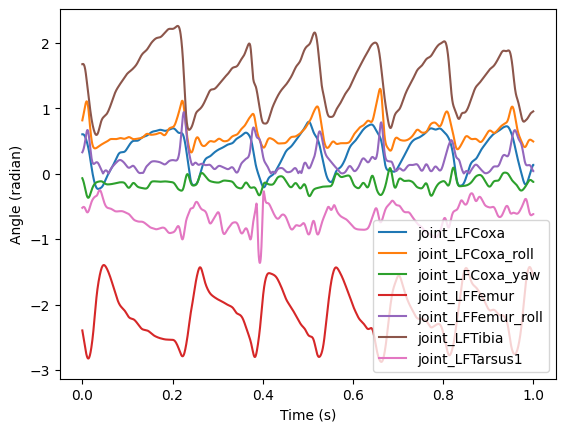

In [6]:
num_joints_to_visualize = 7
plt.plot(np.arange(data_block.shape[1]) * nmf.timestep,
         data_block[:num_joints_to_visualize].T,
         label=nmf.actuated_joints[:num_joints_to_visualize])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Angle (radian)')

Now, we're ready to run our simulation. Tip: this we can use `trange` from the [`tqdm` package](https://github.com/tqdm/tqdm) to add a progress bar. It works the same as Python's built-in `range`, but with a progress bar. You can also use `tqdm.tqdm` on a simple for-loop (without `range`).

In [7]:
# Run simulation
obs, info = nmf.reset()

obs_list = [obs]
k = 0

NSTEPS_STOP = 4000

adhesion_memory = np.zeros(6)
joint_pos_memory = np.zeros(6)

rf_adhesion_actuator_id = [i for i , actuator in enumerate(nmf.adhesion_actuators) if 'RF' in actuator.name][0]
lf_adhesion_actuator_id = [i for i , actuator in enumerate(nmf.adhesion_actuators) if 'LF' in actuator.name][0]

counter = 0

for i in trange(num_steps):
    if counter > 0:
        counter += 1
    if counter > 3:
        joint_pos = joint_pos_memory
        adhesion = adhesion_memory
    else:
        if i > NSTEPS_STOP and (adhesion_memory[rf_adhesion_actuator_id] >= 1 or adhesion_memory[lf_adhesion_actuator_id] <= 0):
            joint_pos = data_block[:, i]
            adhesion = nmf.get_adhesion_vector()
            joint_pos_memory = joint_pos
            adhesion_memory = adhesion
            counter += 1
        else:
            joint_pos = data_block[:, i]
            adhesion = nmf.get_adhesion_vector()
            joint_pos_memory = joint_pos
            adhesion_memory = adhesion
    action = {'joints': joint_pos, "adhesion": adhesion}
    obs, reward, terminated, truncated, info = nmf.step(action)
    if i > NSTEPS_STOP - 200 and counter < 200:
        render_status = nmf.render()
    obs_list.append(obs)

100%|██████████| 10000/10000 [00:25<00:00, 391.84it/s]


As before, we save and inspect the video:

In [8]:
video_path = Path('outputs/video.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

# Get closeview and forces foreleg adhesion

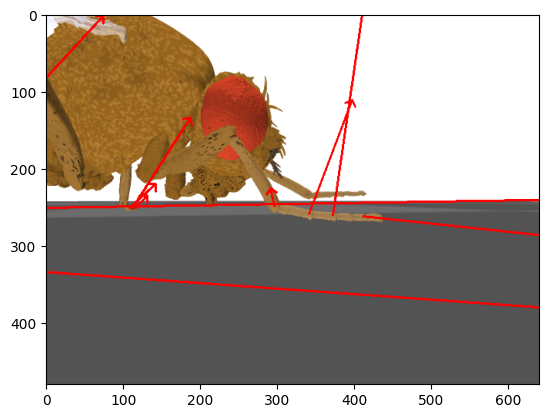

In [9]:
img_last = nmf.get_last_frame()
plt.imshow(img_last, cmap='gray')

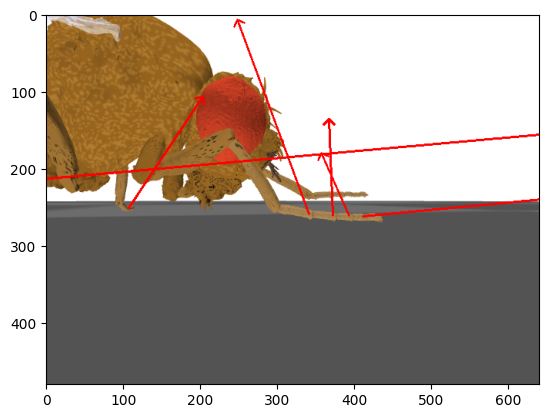

In [10]:
width, height = nmf.sim_params.render_window_size
camera = nmf.sim_params.render_camera
if nmf.sim_params.align_camera_with_gravity:
    nmf.rotate_camera()
img = nmf.physics.render(width=width, height=height, camera_id=camera)
img = nmf._draw_contacts(img)

plt.imshow(img)

In [11]:
width, height = sim_params.render_window_size
nmf.sim_params.draw_contacts = False

img = nmf.physics.render(width=width, height=height, camera_id=nmf.sim_params.render_camera)
dm_camera = dm_control.mujoco.Camera(
                nmf.physics,
                camera_id=nmf.sim_params.render_camera,
                width=width,
                height=height,
            )

scaling_factor = 0.05

camera_matrix = dm_camera.matrix
arrow_start_adh = nmf.physics.named.data.geom_xpos['Animat/RFTarsus5_collision'].copy()
arrow_end_adh = arrow_start_adh + np.array([0.0, 0.0, -1.0])*nmf.sim_params.adhesion_gain*scaling_factor

arrow_starts_contact = []
arrow_ends_contact = []
for i in range(1, 6):
    index_RFTarsus_contact = nmf.contact_sensor_placements.index(f"Animat/RFTarsus{i}")
    arrow_starts_contact.append(nmf.physics.named.data.geom_xpos[f"Animat/RFTarsus{i}_collision"].copy())
    arrow_ends_contact.append(arrow_starts_contact[-1] + obs['contact_forces'][:, index_RFTarsus_contact])

arrows_contacts = np.hstack([arrow_starts_contact, arrow_ends_contact]).reshape((-1, 3))

xyz_global = np.vstack([arrow_start_adh, arrow_end_adh,
                        arrows_contacts]).T

# Camera matrices multiply homogenous [x, y, z, 1] vectors.
corners_homogeneous = np.ones((4, xyz_global.shape[1]), dtype=float)
corners_homogeneous[:3, :] = xyz_global

# Project world coordinates into pixel space. See:
# https://en.wikipedia.org/wiki/3D_projection#Mathematical_formula
xs, ys, s = camera_matrix @ corners_homogeneous

# x and y are in the pixel coordinate system.
x = np.rint(xs / s).astype(int)
y = np.rint(ys / s).astype(int)

In [12]:
x, y

(array([ 426,  426,  323,  323,  362,  264,  387,  379,  406,  368,  426,
        1420]),
 array([263, 475, 255, 255, 261,   5, 262, 136, 263, 181, 263, 170]))

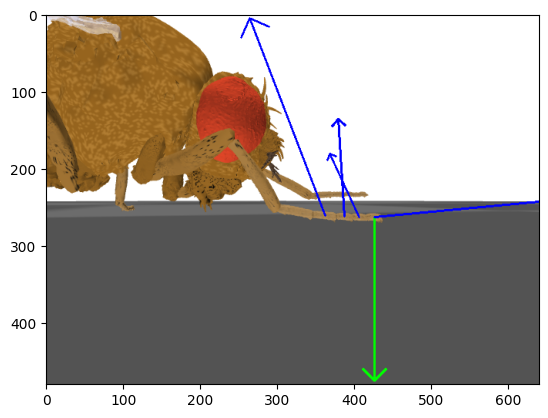

In [13]:
rgb_contact= (0, 0, 255)
rgb_adhesion = (0, 255, 0)

img = img.astype(np.uint8)
for i in range(0, len(x), 2):
    pts1 = x[i], y[i]
    pts2 = x[i+1], y[i+1]
    rgb = rgb_contact
    if i == 0:
        rgb = rgb_adhesion
    if not np.any(pts1 == pts2):
        img = cv2.arrowedLine(img, pts1, pts2, rgb, 2)
# add text
font = cv2.FONT_HERSHEY_SIMPLEX
# img = cv2.putText(img, 'FAdhesion', (width-200, 30), font, 1, rgb_adhesion, 2, cv2.LINE_AA)
# img = cv2.putText(img, 'FContact', (width-200, 60), font, 1, rgb_contact, 2, cv2.LINE_AA)

plt.imshow(img)